----
# A: Clean the Data
----

In [14]:
import re
import nltk
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
wl = nltk.WordNetLemmatizer()

In [16]:
data = pd.read_csv('SMSSpamCollection.tsv', header=None, sep='\t')
data.columns = ['label', 'text']

In [17]:
def count_punctuations(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count / (len(text)-text.count(' ')), 3) * 100

In [18]:
data['text_length'] = data['text'].apply(lambda x: len(x)-x.count(' ') )
data['punctuarion %'] = data['text'].apply(lambda x: count_punctuations(x))

In [19]:
def clean_data(text):
    lower_words = ''.join([char.lower() for char in text if char not in string.punctuation])
    tokenize = re.split('\W+', text)
    no_stopwords_lemma = [wl.lemmatize(word) for word in tokenize if word not in stopwords]
    return no_stopwords_lemma

In [20]:
vectorize = TfidfVectorizer(analyzer=clean_data)
X = vectorize.fit_transform(data['text'])

In [21]:
# create a new dataframe with the necessary data
X_features_df = pd.concat([data['text_length'], data['punctuarion %'], pd.DataFrame(X.toarray())], axis=1)
X_features_df.head()

,text_length,punctuarion %,0,1,2,3,4,5,6,7,...,10305,10306,10307,10308,10309,10310,10311,10312,10313,10314
0,160,2.5,0.050636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.070893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.078096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----
# B: ML Classifire
----

### B1: RandomForestClassifire

----
##### - Running RandomForestClassifire through Cross-Validation

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [26]:
?RandomForestClassifier

In [32]:
random_forest_classifire = RandomForestClassifier(n_jobs=-1)  # n_jobs=-1 means: Run parallel
k_fold = KFold(n_splits=5)
cross_validation_score = cross_val_score(random_forest_classifire, X_features_df, data['label'], cv=k_fold, n_jobs=-1)
cross_validation_score

array([0.97666068, 0.97217235, 0.97396768, 0.96585804, 0.97394429])

Here is our five iterations and you can see the Accuracies of each iteration

----
##### - Running RandomForestClassifire through Holdout Test Set

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [50]:
# First we need to split our data to train and test data. Important to know, the split method will have four outputs!
X_train, X_test, y_train, y_test = train_test_split(X_features_df, data['label'], test_size=.2)

In [51]:
random_forest_classifire = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=20)

model = random_forest_classifire.fit(X_train, y_train)

In [52]:
# let's find out what are our top 10 most important features
sorted(zip(model.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.04074284046019867, 'text_length'),
 (0.02757779883918845, 8911),
 (0.023757334943858135, 1859),
 (0.02261418033069824, 10231),
 (0.02249453365560611, 7655),
 (0.02171250417595976, 1398),
 (0.021537259020563516, 5179),
 (0.018819824852677185, 9792),
 (0.018238299228161073, 8382),
 (0.017987938641294398, 360)]

In [58]:
# and now we can see the Prediction
y_predection = model.predict(X_test)

# precision_recall_fscore_support
precision, recall, fscore, support = score(y_test, y_predection, pos_label='spam', average='binary')

print('Precision: {}\nRecall: {}\nAccuracy: {}'.format(
    round(precision, 3),
    round(recall, 3), 
    round((y_predection==y_test).sum()/len(y_predection), 3)))

Precision: 1.0
Recall: 0.57
Accuracy: 0.936


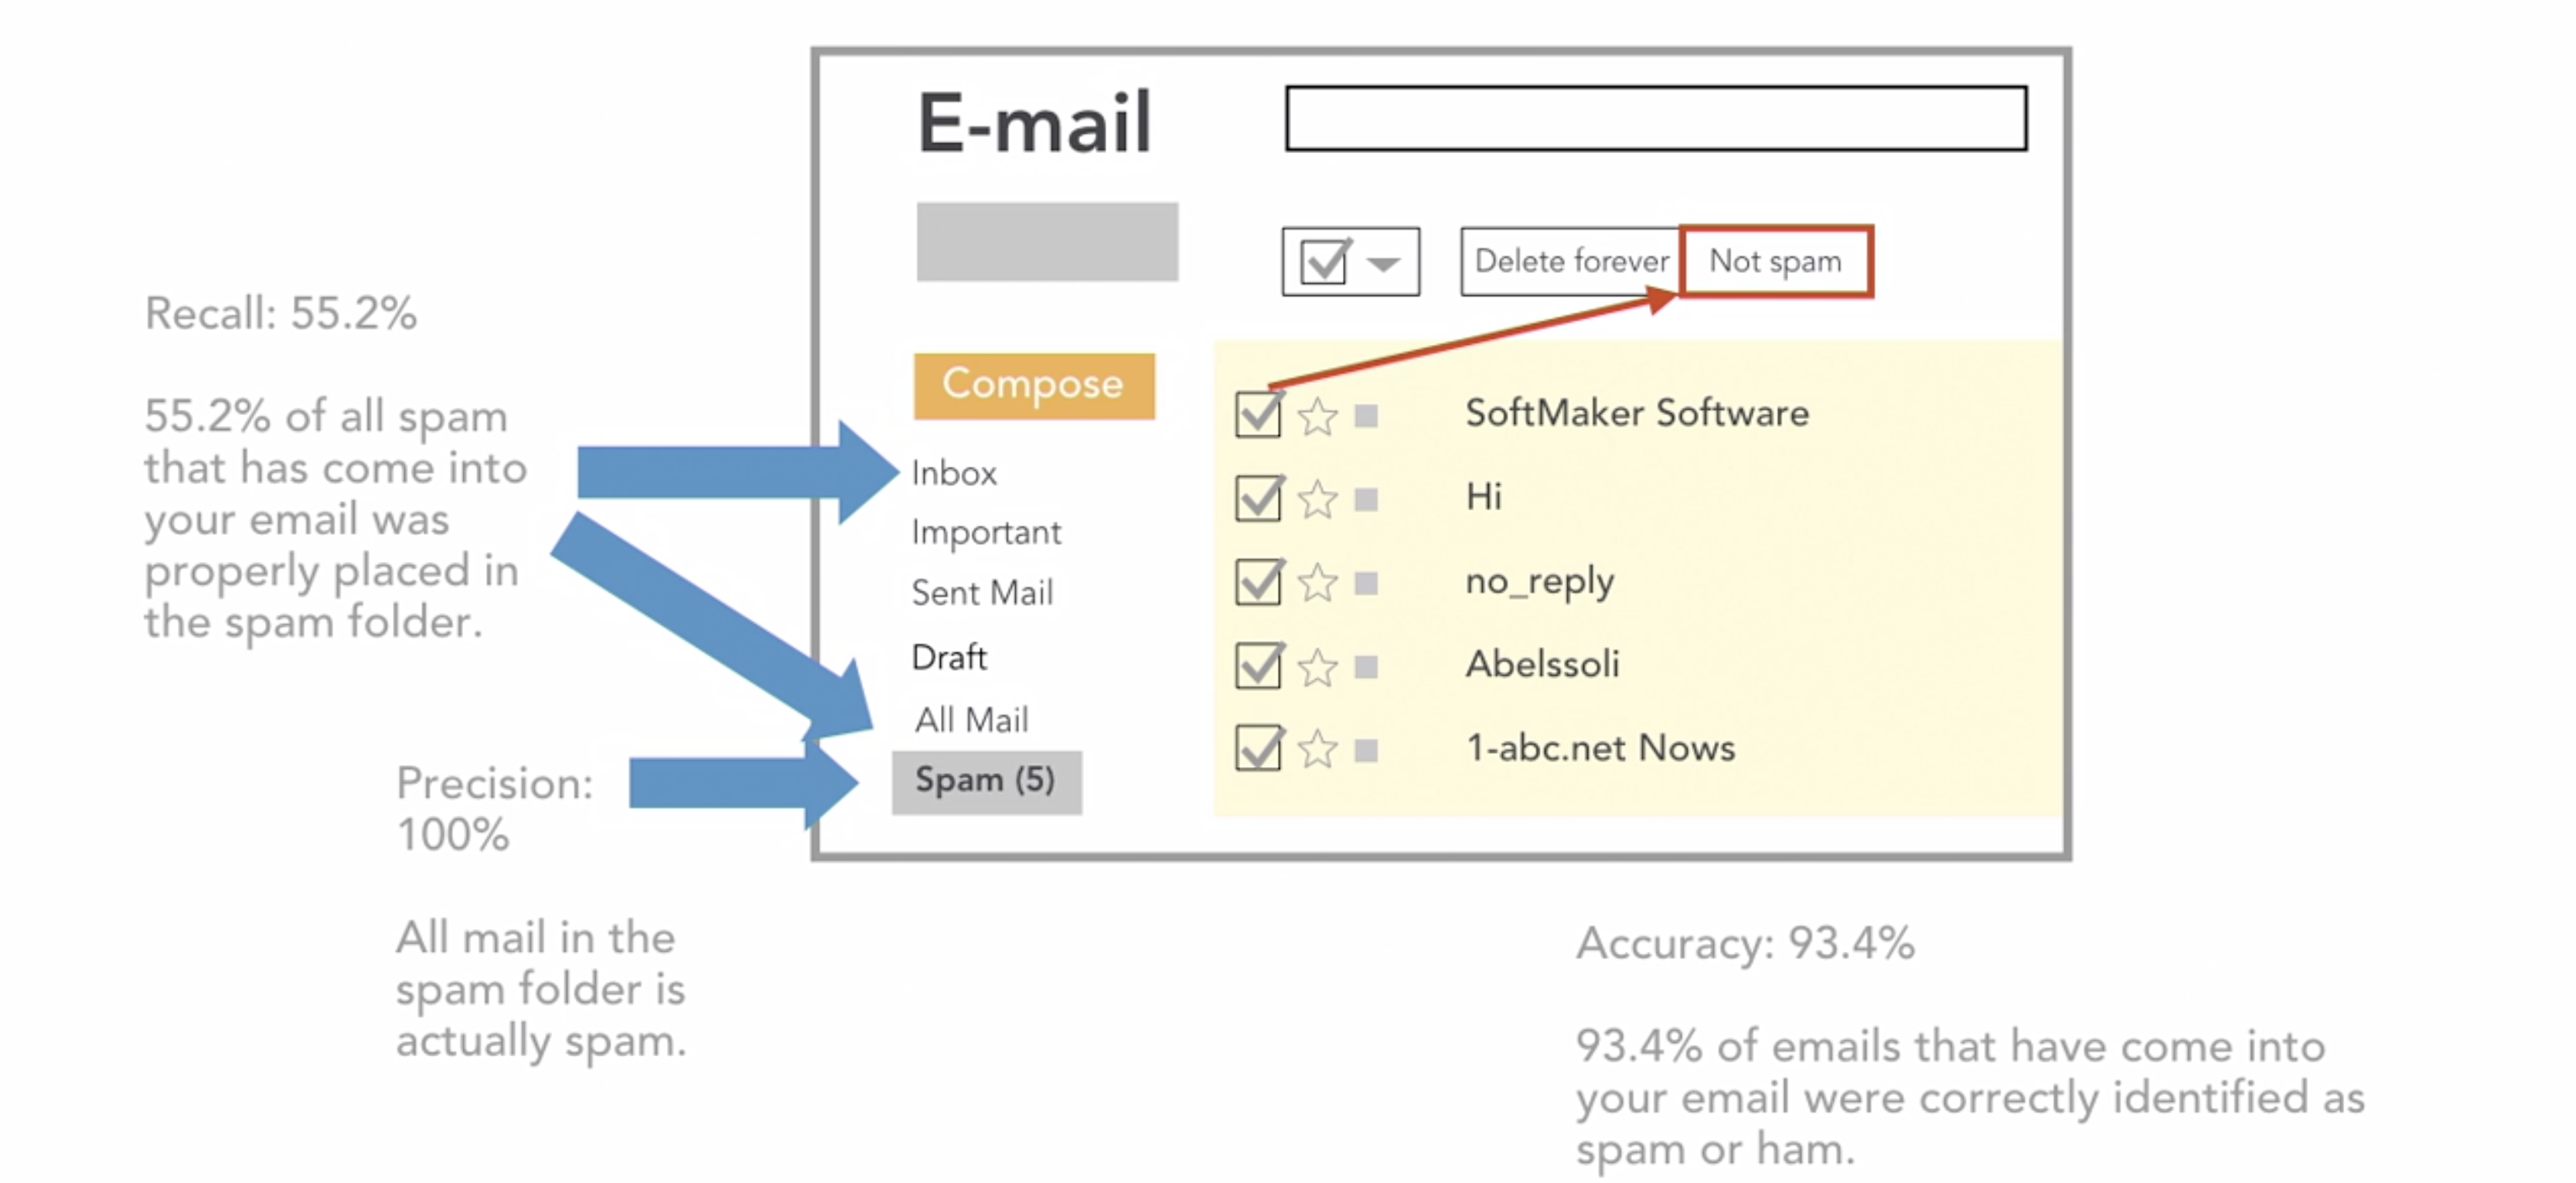

----
##### RandomForestClassifier with Grid-Search

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_features_df, data['label'], test_size=.2)

In [63]:
def train_RFC(n_est, depth):
    rfc = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    model = rfc.fit(X_train, y_train)
    y_predection = model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_predection, pos_label='spam', average='binary')
    print('Precision: {} Recall: {} Accuracy: {} Est: {} Depth: {}\n'.format(
        round(precision, 3),
        round(recall, 3), 
        round((y_predection==y_test).sum()/len(y_predection), 3),
        n_est,
        depth
    ))

In [64]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30, None]:
        train_RFC(n_est, depth)

Precision: 1.0 Recall: 0.307 Accuracy: 0.915 Est: 10 Depth: 10

Precision: 0.989 Recall: 0.686 Accuracy: 0.961 Est: 10 Depth: 20

Precision: 1.0 Recall: 0.788 Accuracy: 0.974 Est: 10 Depth: 30

Precision: 1.0 Recall: 0.861 Accuracy: 0.983 Est: 10 Depth: None

Precision: 1.0 Recall: 0.226 Accuracy: 0.905 Est: 50 Depth: 10

Precision: 1.0 Recall: 0.584 Accuracy: 0.949 Est: 50 Depth: 20

Precision: 1.0 Recall: 0.796 Accuracy: 0.975 Est: 50 Depth: 30

Precision: 1.0 Recall: 0.883 Accuracy: 0.986 Est: 50 Depth: None

Precision: 1.0 Recall: 0.175 Accuracy: 0.899 Est: 100 Depth: 10

Precision: 1.0 Recall: 0.606 Accuracy: 0.952 Est: 100 Depth: 20

Precision: 1.0 Recall: 0.81 Accuracy: 0.977 Est: 100 Depth: 30

Precision: 1.0 Recall: 0.912 Accuracy: 0.989 Est: 100 Depth: None



In this example, as the depth increases from 10, to 20, to 30, and eventually to none, the recall increases quite drastically, while you see the precision doesn't really drop. So the model is getting much better and more aggressive as the depth increases. On the other side, you'll notice that adding estimators might be helping a little bit, but the improvement isn't as drastic as adding depth to the individual trees. Now we know that the best random forest model is one with very high max depth, probably no limit. And number of estimators plays a little bit of a role, but not nearly as much as max depth.